<h3>Load and format data</h3>

In [7]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import matplotlib
import copy
from matplotlib.colors import LogNorm

import seaborn as sns

from bokeh.plotting import figure, show, output_notebook
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.layouts import gridplot
from bokeh.resources import CDN
from bokeh.embed import file_html

folder = '/Users/Claire/Dropbox/Allen Institute Stuff/'
mouse_data = 'RNA seq/VISp'
human_data = 'RNA seq/Human Developmental Transcriptome'

In [8]:
# extract mouse gene names, make a single list of all genes in the "markers present" column
cluster_metadata = pd.read_csv(folder + mouse_data + '/cluster_metadata.csv')
mouse_genes = []
for m in cluster_metadata['markers_present']:
    for marker in m.split(','):        
        mouse_genes += [marker.strip()]

# Save the list mouse cell type-indicator mouse genes to a file       
# with open(folder + human_data + '/mouse_gene_names.csv', 'w+') as myfile:
#     for m in mouse_genes:
#         myfile.write(m + ', ')

# mouse_gene_names.csv used to map to human gene names using BioMart
# http://www.ensembl.org/biomart/martview/

In [9]:
from itertools import islice

# Extract list of human genes (output from BioMart) and create a list of unique human gene names
human_gene_list = pd.read_csv(folder + human_data + '/human_gene_names.csv')
human_genes = human_gene_list['Human gene name'].unique()

# Map from mouse to human genes
gene_names = {}
for i in human_gene_list.index:
    mgene = human_gene_list['Gene name'][i]
    hgene = human_gene_list['Human gene name'][i]
    gene_names[mgene] = hgene

# Map from human genes to clusters
hgenes_to_clusters = {}
for mgene in gene_names.keys():
    hgene = gene_names[mgene]
    clusters_present = []
    for i in cluster_metadata.index:
        if mgene in cluster_metadata['markers_present'][i].split(', '):
            clusters_present += [cluster_metadata['Tasic_et_al_2016_label'][i]]
    hgenes_to_clusters[hgene] = clusters_present

# Map from clusters to human genes
clusters_to_hgenes = {}
for i in cluster_metadata.index:
    cluster_name = cluster_metadata['Tasic_et_al_2016_label'][i]
    hgenes_present = []
    for mgene in cluster_metadata['markers_present'][i].split(', '):
        if mgene in gene_names.keys():
            hgenes_present += [gene_names[mgene]]
    clusters_to_hgenes[cluster_name] = hgenes_present

# Map from clusters to cell types
cluster_to_type = {}
cluster_names = cluster_metadata['Tasic_et_al_2016_label'].values
for cluster_name in cluster_names:
    cluster_id = int(cluster_metadata[cluster_metadata['Tasic_et_al_2016_label'] == cluster_name]['cluster_id'].values[0].replace('f', ''))
    if cluster_id < 24:
        cell_type = 'inhibitory'
    elif cluster_id < 43:
        cell_type = 'excitatory'
    else:
        cell_type = 'glia'
    cluster_to_type[cluster_name] = cell_type
    
# Save the list of unique human genes
# with open(folder + human_data + '/human_gene_names_nice.csv', 'w+') as myfile:
#     for m in human_genes:
#         myfile.write(str(m) + ',')

In [10]:
# Reload data from text files (should be same var names)
human_genes = list(pd.read_csv(folder + human_data + '/human_gene_names_nice.csv'))
mouse_genes = list(pd.read_csv(folder + human_data + '/mouse_gene_names.csv'))

In [11]:
# Load expression data, row and column labels
data = pd.read_csv(folder + human_data + '/genes_matrix_csv/expression_matrix.csv', header = None, index_col = 0)
rows = pd.read_csv(folder + human_data + '/genes_matrix_csv/rows_metadata.csv')
columns = pd.read_csv(folder + human_data + '/genes_matrix_csv/columns_metadata.csv')
genes = list(rows['gene_symbol'])

donors = list(columns['donor_id'])
ages = list(columns['age'])
structure_acr = list(columns['structure_acronym'])
structure_name = list(columns['structure_name'])

In [12]:
# Convert data into a data frame with MultiIndex
arrays = [donors, ages, structure_acr, structure_name]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['donor', 'age', 'structure_acr', 'structure_name'])
data.columns = index

arrays = [genes]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['gene'])
data.index = index
pd.set_option('display.multi_sparse', False)

In [13]:
# Select data from V1 only
data_v1 = data.xs('primary visual cortex (striate cortex, area V1/17)', axis = 1, level = 'structure_name')

In [14]:
# Average over all samples from the same age
ages = data_v1.columns.get_level_values(1).unique()
data_v1_lg = data_v1.groupby(axis = 1, level = 1).mean()

data_v1_lg = data_v1_lg[ages]

In [15]:
# Select data from genes of interest only
data_v1_small = data_v1_lg[data_v1_lg.index.isin(set(human_genes))]

In [16]:
# Reformat data frame so that gene expression is a single column
df = pd.DataFrame(data_v1_small.unstack())
df.reset_index(inplace = True)
df.columns = ['age', 'gene', 'expression']

# Convert ages to PCW
def age_in_pcw(age):
    num, unit = age.split(' ')
    if unit == 'pcw':
        return int(num)
    elif unit == 'mos':
        return int(4.34524 * float(num)) + 40
    elif unit == 'yrs':
        return int(52.1429 * float(num)) + 40
    else:
        return 'What are these units???'

ages = []
for age in df.age:
    ages += [age_in_pcw(age)]
df['age_pcw'] = ages       

In [17]:
# Calculate expression ratio between 12 pcw and 3 years

def exp_ratio(df, gene, age1, age2):
    data_gene = df[df['gene'] == gene]
    expression_1 = data_gene[data_gene.age == age1].expression.mean()
    expression_2 = data_gene[data_gene.age == age2].expression.mean()
    if expression_1 == 0:
        return 10
    else:
        return expression_2 / expression_1

ratios = []
for gene in df.gene:
    ratios += [exp_ratio(df, gene, '12 pcw', '3 yrs')]    
df['ratio'] = ratios

In [18]:
# Make a new dataframe containing only developmentally regulated genes, as well as a list of these genes

df_interesting = df[(df.ratio > 50) | (df.ratio < -50)]
genes_interesting = df_interesting.gene.unique()

In [19]:
# Filter data matrix by developmental regulation, get into correct format for plotting
data_plot = data_v1_small[data_v1_small.index.isin(genes_interesting)].copy()
data_plot = data_plot[(data_plot.index != 'FCGR2B') & (data_plot.index != 'AKR1C3') & (data_plot.index != 'AKR1C4') & (data_plot.index != 'FCGR2C')]
data_plot += 1

# Label genes which are indicative of cell type, create color labels for cluster types
type_list = [cluster_to_type[hgenes_to_clusters[gene][0]] for gene in data_plot.index]
color_list = [{'inhibitory': 'red', 'excitatory': 'green', 'glia': 'blue'}[type] for type in type_list]
cluster_list = [str(hgenes_to_clusters[gene]) + ': ' + gene for gene in data_plot.index]
data_plot.index = cluster_list

In [20]:
# Data for all genes from a single transcriptionally-defined cluster

cluster_to_data = {}
for cluster in clusters_to_hgenes.keys():
    genes_clus = clusters_to_hgenes[cluster]
    data_clus = df[df.gene.isin(genes_clus)]
    cluster_to_data[cluster] = data_clus

In [21]:
# Expression matrix average within a transcriptionally-defined cluster

data_v1_small.head()

cluster_to_matrix = {}
for cluster in clusters_to_hgenes.keys():
    genes_clus = clusters_to_hgenes[cluster]
    data_clus = data_v1_small[data_v1_small.index.isin(genes_clus)]
    cluster_to_matrix[cluster] = data_clus

cluster_means = []
for clus in cluster_names:
    data_clus = cluster_to_matrix[clus]
    data_mean = data_clus.mean(axis = 0)
    cluster_means += [data_mean]
    
cluster_means = pd.DataFrame(cluster_means)
cluster_means.index = cluster_names

In [22]:
# Select a subset of the cluster-averaged data for which we have data from corresponding cre lines

cre_lines = ['Ndnf Car4', 'Ndnf Cxcl14', 'Vip Chat', 'Sst Cbln4', 'Vip Parm1', 'L6b Serpinb11', 'L6b Rgs12',
            'L6a Mgp', 'L6a Sla', 'L4 Ctxn3','L4 Scnn1a','L4 Arf5','L2/3 Ptgs2','L5a Batf3','L5 Hsd11b1']

means_cre = cluster_means[cluster_means.index.isin(cre_lines)]

<h3>Print out data</h3>

In [23]:
# Gene lists and dictionaries

print('mouse_genes')
print(mouse_genes[:10])
print('human_genes')
print(human_genes[:10])
print('gene_names')
print(list(islice(gene_names.items(), 10)))
print('hgenes_to_clusters')
print(list(islice(hgenes_to_clusters.items(), 5)))
print('clusters_to_hgenes')
print(list(islice(clusters_to_hgenes.items(), 5)))
print('cluster_to_type')
print(list(islice(cluster_to_type.items(), 5)))

mouse_genes
['Crispld2', ' Cxcl14', ' Tpm2', ' Itih5', ' Cox6a2', ' Cxcl14.1', ' Car4', ' Tac2', ' Reln', ' Npy2r']
human_genes
['CLDN11', 'NTSR2', 'PCDH18', 'GPR37', 'HK2', 'TMEM119', 'KIT', 'HAS2', 'SPP1', 'NOSTRIN']
gene_names
[('Eml1', 'EML1'), ('Edn3', 'EDN3'), ('Dgkb', 'DGKB'), ('Tnni3k', 'FPGT-TNNI3K'), ('Ddit4l', 'DDIT4L'), ('Qrfpr', nan), ('Fam84b', 'FAM84B'), ('Irs4', 'IRS4'), ('Cspg4', 'CSPG4'), ('Gm5622', nan)]
hgenes_to_clusters
[(nan, ['Astro Aqp4']), ('FREM1', ['Sncg']), ('NFIB', ['Igtp', 'Pvalb Cpne5']), ('ABI3', ['Micro Ctss']), ('GPR17', ['OPC Pdgfra', 'Oligo 9630013A20Rik '])]
clusters_to_hgenes
[('L5b Chrna6', ['CHRNB3', 'SCML2', 'NGB', 'KLK8', 'DDIT4L', 'FAM84B']), ('Oligo 9630013A20Rik ', ['BRCA1', 'RNF122', 'MBP', 'ZCCHC18', 'ENPP6', 'KIF19', 'ENPP6', 'DCT', 'TMEFF2', 'GPR17', 'KIAA1644', 'ST18', 'VCAN', 'BCAN', nan, 'CLDN11', nan]), ('Vip Mybpc1', ['CRISPLD2', 'CXCL14', 'TPM2', 'ITIH5', 'COX6A2']), ('Vip Parm1', ['CXCL14', 'CA4', 'TAC3']), ('Sst Th', ['GABRG1', 

In [24]:
# Info about which genes go with which clusters

print('cluster_metadata') 
print(cluster_metadata.shape)
cluster_metadata.head(2)

cluster_metadata
(49, 10)


,cluster_order,cluster_id,vignette_label,vignette_color,group,markers_present,markers_sparse,genes_absent,Tasic_et_al_2016_label,Unnamed: 9
0,7,f01,Vip Mybpc1,#BB36BF,Vip,"Crispld2, Cxcl14, Tpm2, Itih5, Cox6a2",Tmem182,"Npy2r, Sorl1, Car4",Vip Mybpc1,NaN
1,6,f02,Vip Cxcl14_Car4,#C994C7,Vip,"Cxcl14, Car4, Tac2","Dmp1, Syt10","Mybpc1, Npy2r, Slc44a5",Vip Parm1,NaN


In [25]:
# Expression matrix for all genes and samples

print('data')
print(data.shape)
data.head(2)

data
(52376, 524)


donor,13058,13058,13058,13058,13058,13058,13058,13058,13058,13058,...,12304,12304,12304,12304,12304,12304,12304,12304,12304,12304
age,8 pcw,8 pcw,8 pcw,8 pcw,8 pcw,8 pcw,8 pcw,8 pcw,8 pcw,8 pcw,...,40 yrs,40 yrs,40 yrs,40 yrs,40 yrs,40 yrs,40 yrs,40 yrs,40 yrs,40 yrs
structure_acr,Ocx,M1C-S1C,AMY,MGE,STC,URL,CGE,DTH,MFC,DFC,...,A1C,CBC,V1C,OFC,STC,IPC,M1C,HIP,STR,S1C
structure_name,occipital neocortex,primary motor-sensory cortex (samples),amygdaloid complex,medial ganglionic eminence,posterior (caudal) superior temporal cortex (area 22c),upper (rostral) rhombic lip,caudal ganglionic eminence,dorsal thalamus,anterior (rostral) cingulate (medial prefrontal) cortex,dorsolateral prefrontal cortex,...,primary auditory cortex (core),cerebellar cortex,"primary visual cortex (striate cortex, area V1/17)",orbital frontal cortex,posterior (caudal) superior temporal cortex (area 22c),posteroventral (inferior) parietal cortex,"primary motor cortex (area M1, area 4)",hippocampus (hippocampal formation),striatum,"primary somatosensory cortex (area S1, areas 3,1,2)"
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
TNMD,0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,0.181220,...,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134


In [26]:
# Expression matrix for all genes and all samples from V1

print('data_v1')
print(data_v1.shape)
data_v1.head(2)

data_v1
(52376, 33)


donor,12835,12960,13060,12820,12834,12888,12287,12837,12879,12880,...,12981,12289,12831,12984,12832,13057,12290,12302,12303,12304
age,12 pcw,12 pcw,12 pcw,13 pcw,13 pcw,13 pcw,16 pcw,16 pcw,16 pcw,17 pcw,...,8 yrs,11 yrs,13 yrs,18 yrs,19 yrs,21 yrs,30 yrs,36 yrs,37 yrs,40 yrs
structure_acr,V1C,V1C,V1C,V1C,V1C,V1C,V1C,V1C,V1C,V1C,...,V1C,V1C,V1C,V1C,V1C,V1C,V1C,V1C,V1C,V1C
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.490831,3.958576,4.990750,5.111040,5.164254,6.355281,7.556875,8.454797,12.024979,6.850831,...,2.313554,2.016692,2.957646,5.151395,1.05204,2.059929,0.951947,1.888270,1.94108,2.277359
TNMD,0.082153,0.000000,0.023499,0.029533,0.000000,0.000000,0.000000,0.027518,0.043824,0.021197,...,0.000000,0.059696,0.038216,0.091347,0.03411,0.028417,0.085196,0.057291,0.07110,0.061869


In [27]:
# Expression matrix for all genes and all samples from V1
# Samples from the same developmental age have been averaged

print('data_v1_lg')
print(data_v1_lg.shape)
data_v1_lg.head(2)

data_v1_lg
(52376, 24)


age,12 pcw,13 pcw,16 pcw,17 pcw,19 pcw,21 pcw,24 pcw,26 pcw,37 pcw,4 mos,...,8 yrs,11 yrs,13 yrs,18 yrs,19 yrs,21 yrs,30 yrs,36 yrs,37 yrs,40 yrs
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,4.146719,5.543525,9.345550,6.850831,3.426339,4.162621,11.506450,5.103003,10.825351,3.497182,...,5.380747,2.016692,2.957646,5.151395,1.05204,2.059929,0.951947,1.888270,1.94108,2.277359
TNMD,0.035217,0.009844,0.023781,0.021197,0.000000,0.039491,0.029222,0.007358,0.028424,0.127294,...,0.000000,0.059696,0.038216,0.091347,0.03411,0.028417,0.085196,0.057291,0.07110,0.061869


In [28]:
# Expression matrix for cell type-indicator genes and all samples from V1
# Samples from the same developmental age have been averaged

print('data_v1_small')
print(data_v1_small.shape)
data_v1_small.head(2)

data_v1_small
(319, 24)


age,12 pcw,13 pcw,16 pcw,17 pcw,19 pcw,21 pcw,24 pcw,26 pcw,37 pcw,4 mos,...,8 yrs,11 yrs,13 yrs,18 yrs,19 yrs,21 yrs,30 yrs,36 yrs,37 yrs,40 yrs
gene,,,,,,,,,,,,,,,,,,,,,
TNMD,0.035217,0.009844,0.023781,0.021197,0.0,0.039491,0.029222,0.007358,0.028424,0.127294,...,0.000000,0.059696,0.038216,0.091347,0.034110,0.028417,0.085196,0.057291,0.071100,0.061869
PRSS22,0.008313,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.052705,0.000000,0.000000,...,0.025303,0.000000,0.044393,0.000000,0.075498,0.032564,0.098293,0.000000,0.027655,0.036179


In [29]:
# Restructured version of data_v1_small, with age in pcw and developmental expression ratio

print('df')
print(df.shape)
df.head(2)

df
(7656, 5)


,age,gene,expression,age_pcw,ratio
0,12 pcw,TNMD,0.035217,12,0.104451
1,12 pcw,PRSS22,0.008313,12,6.146091


In [30]:
# Previous dataframe, filtered for only genes with sufficiently increased transcription between 12 pcw and 3 yrs

print('genes_interesting')
print(len(genes_interesting))
print(genes_interesting)

print('df_interesting')
print(df_interesting.shape)
df_interesting.head(2)

genes_interesting
46
['HHATL' 'PLEKHB1' 'FCGR2B' 'SLC4A4' 'SLCO1A2' 'MLC1' 'ASPA' 'ALDOC'
 'CRYAB' 'ENDOU' 'TPD52L1' 'EFEMP1' 'F3' 'CASQ2' 'CHRNA2' 'GJB6' 'EDN3'
 'BCAN' 'ANO3' 'NT5E' 'EDNRB' 'ENPP2' 'SLCO1C1' 'GPR17' 'ALDH1L1' 'DDIT4L'
 'CXCL14' 'CRH' 'SLC39A12' 'SPARCL1' 'SCRG1' 'ACSL6' 'TAC3' 'CA4' 'CORO6'
 'FAM107A' 'MOBP' 'NTSR2' 'RSPO1' 'HSPB3' 'CPNE7' 'GABRD' 'COL14A1'
 'AKR1C3' 'MBP' 'MOG']
df_interesting
(1104, 5)


,age,gene,expression,age_pcw,ratio
6,12 pcw,HHATL,0.004287,12,4686.944600
9,12 pcw,PLEKHB1,0.434597,12,329.308428


In [31]:
# Expression matrix limited to developmentally regulated genes, labeled with clusters that correspond to each gene
# Comes from data_v1_small, limited to genes in genes_interesting

print('data_plot')
print(data_plot.shape)
data_plot.head(2)

data_plot
(44, 24)


age,12 pcw,13 pcw,16 pcw,17 pcw,19 pcw,21 pcw,24 pcw,26 pcw,37 pcw,4 mos,...,8 yrs,11 yrs,13 yrs,18 yrs,19 yrs,21 yrs,30 yrs,36 yrs,37 yrs,40 yrs
['L5 Ucma']: HHATL,1.004287,1.006118,1.072498,1.070473,1.177478,1.032001,1.098486,26.033454,1.234200,2.77437,...,20.086498,10.753898,15.766688,38.296371,19.230714,14.894746,30.989492,18.554037,40.458228,14.64251
['L6a Sla']: PLEKHB1,1.434597,1.809677,2.157875,2.429406,2.188692,2.302058,4.098157,124.155432,20.542225,18.80195,...,93.351894,107.818108,145.490520,227.297229,66.608414,66.976087,66.332546,58.365092,139.233414,105.71068


In [32]:
# Expression matrix of all genes in the dataset, with means calculated for all genes within a cluster

print('cluster_means')
print(cluster_means.shape)
cluster_means.head(2)

cluster_means
(49, 24)


age,12 pcw,13 pcw,16 pcw,17 pcw,19 pcw,21 pcw,24 pcw,26 pcw,37 pcw,4 mos,...,8 yrs,11 yrs,13 yrs,18 yrs,19 yrs,21 yrs,30 yrs,36 yrs,37 yrs,40 yrs
Vip Mybpc1,0.685474,0.706067,1.899606,2.458430,3.185438,2.713017,3.812552,67.382073,29.427325,22.493569,...,22.593407,8.637763,23.179242,41.145189,7.767744,7.126170,6.091497,6.320431,7.265666,12.869798
Vip Parm1,0.289335,0.223197,0.846016,1.662707,2.731197,2.766577,4.719119,111.467119,44.661349,42.271224,...,41.885698,19.154537,43.060015,67.834692,19.015512,13.449401,16.290341,13.546308,14.618938,22.378294


<h3>Plot</h3>

In [33]:
# % matplotlib inline

# sns.set(style="ticks", context="talk")

# pal = sns.hls_palette(len(df_interesting.gene.unique()), l=.4, s=.9)

# g = sns.lmplot(x="age_pcw", y='expression', hue="gene", data=df_interesting,
#                palette=pal, size=7, legend = False)

# plt.legend(loc='upper left')

# sns.plt.xlim(0, age_in_pcw('3 yrs'))

# plt.figure()
# for n, color in zip(df.gene[20:30], ['red', 'green', 'blue', 'yellow', 'orange', 'magenta', 'pink', 'black', 'brown', 'teal']):    
#     plt.plot(df[df['gene'] == n]['age_pcw'], df[df['gene'] == n]['expression'], 'o', color = color)
# plt.xlim(0, 100)

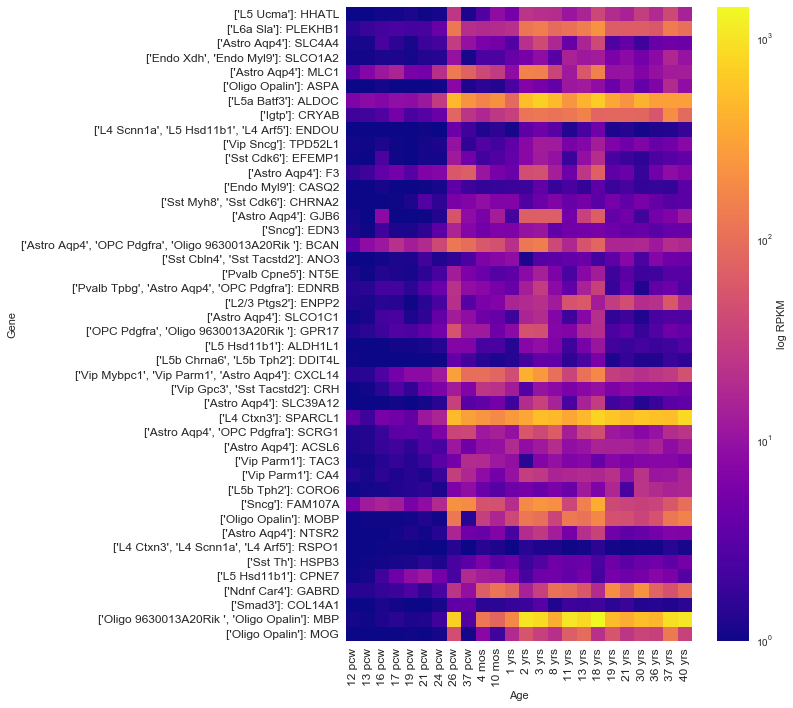

In [224]:
# Heatmap of developmentally regulated genes, log scale

my_cmap = copy.copy(matplotlib.cm.get_cmap('plasma'))
my_cmap.set_bad((0,0,0))
fig, ax = plt.subplots(figsize = (10, 10))
g = ax.imshow(data_plot, interpolation = 'None', cmap = my_cmap, norm = LogNorm())
plt.colorbar(g, label = 'log RPKM')
ax.grid(False)
ax.set_xticks(range(len(data_plot.columns)))
ax.set_yticks(range(len(data_plot.index)))
ax.set_xticklabels(list(data_plot.columns), rotation = 90, fontsize = 12)
ax.set_yticklabels(list(data_plot.index), fontsize = 12)
plt.xlabel('Age')
plt.ylabel('Gene')
fig.tight_layout()
plt.show()

//anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


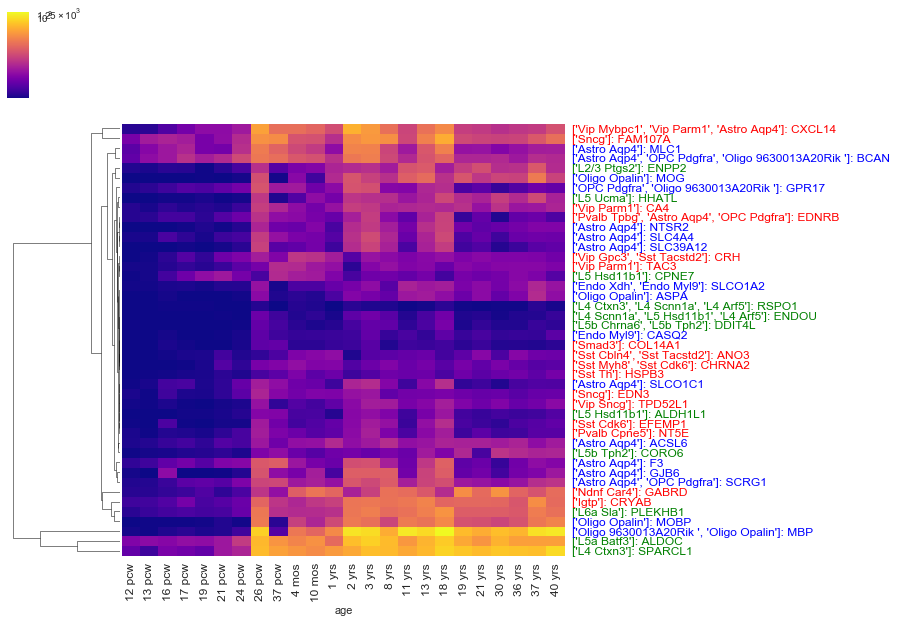

In [232]:
m = sns.clustermap(data_plot, col_cluster = False, row_cluster = True, z_score = None, figsize = (10, 10),
                     cmap = 'plasma', norm = LogNorm())
plt.setp(m.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize = 12)
plt.setp(m.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize = 12)
m.ax_heatmap.yaxis.set_label('Cell Cluster(s): Gene')
colors_reordered = np.array(color_list)[m.dendrogram_row.reordered_ind][::-1]
for xtick, color in zip(m.ax_heatmap.get_yticklabels(), colors_reordered):
    xtick.set_color(color)

plt.show()

In [73]:
output_notebook()

tools = "hover,save,pan,box_zoom,reset,wheel_zoom"

plots = []

for cluster_name in cluster_names:
    cluster_genes = clusters_to_hgenes[cluster_name]
    cluster_data = cluster_to_data[cluster_name]
    cell_type = cluster_to_type[cluster_name]
    title_color = {'inhibitory': 'red', 'excitatory': 'green', 'glia': 'blue'}[cell_type]
    
    colors = sns.husl_palette(n_colors = len(cluster_genes)).as_hex()

    p = figure(plot_width=200, plot_height=200, title = cluster_name, x_axis_type = 'log', y_axis_type = 'log', tools = tools)
    p.title.text_color = title_color
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = 'Age (PCW)'
    p.yaxis.axis_label = 'RPKM'
    for i, gene in enumerate(cluster_genes):
        data_gene = cluster_data[cluster_data.gene == gene]
        p.line('age_pcw', 'expression', source = data_gene, color = colors[i], line_width = 2)
    p.select_one(HoverTool).tooltips = [
         ('Gene', '@gene'),
         ('Age', '@age_pcw'),
         ('RPKM', '@expression')]
    plots.append(p)

plots_nested = [plots[i:i+10] for i in range(0, len(plots), 10)]
    
grid = gridplot(plots_nested)
# show(grid)

with open(folder + human_data + '/test.html', 'w+') as myfile:
        myfile.write(file_html(grid, CDN, 'test'))

Loading BokehJS ...

//anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


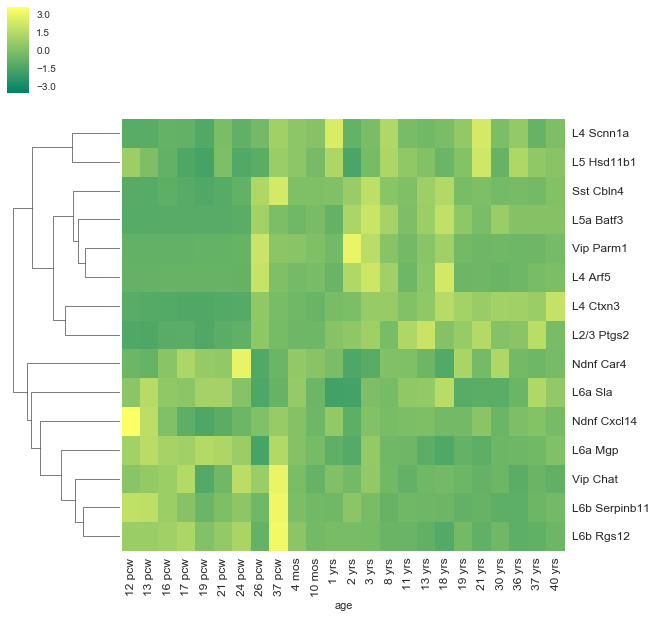

In [87]:
my_cmap = copy.copy(matplotlib.cm.get_cmap('summer'))
map = sns.clustermap(means_cre, col_cluster = False, row_cluster = True, z_score = 0, figsize = (10, 10),
                     cmap = my_cmap)
plt.setp(map.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize = 12)
plt.setp(map.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize = 12)
plt.show()